# Adding the convolutional layers back in

In [4]:


import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torchvision.models as models
from torch.cuda.amp import GradScaler, autocast

# -----------------------------
# 1. Dataset Definition
# -----------------------------

class CachedDataset(Dataset):
    def __init__(self, dataframe, cached_dir, original_image_size=(2560, 1440), resized_image_size=(128, 128)):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image IDs, bbox coordinates, and class labels.
            cached_dir (str): Directory where cached image tensors are stored.
            original_image_size (tuple): Original image size as (width, height).
            resized_image_size (tuple): Desired image size as (width, height).
        """
        self.dataframe = dataframe
        self.cached_dir = cached_dir
        self.original_width, self.original_height = original_image_size
        self.resized_width, self.resized_height = resized_image_size
        self.transform = transforms.Compose([
            transforms.Resize(resized_image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                                 std=[0.229, 0.224, 0.225])   
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]['Image_ID']
        cached_path = os.path.join(self.cached_dir, f"{image_id}.pt")
        try:
            image = torch.load(cached_path)
        except Exception as e:
            print(f"Error loading cached image {cached_path}: {e}")
            # Return dummy data or handle appropriately
            image = torch.zeros(3, self.resized_height, self.resized_width)  # Adjust size accordingly
            bbox = torch.zeros(4, dtype=torch.float32)
            label = torch.tensor(0, dtype=torch.long)
            return image, {'boxes': bbox, 'labels': label}
        
        # Extract bounding box coordinates and scale them
        # Assuming original bbox coordinates are based on original_image_size
        bbox_original = [
            self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']
        ]
        # Scale bbox coordinates to match resized images
        scale_x = self.resized_width / self.original_width
        scale_y = self.resized_height / self.original_height
        bbox_scaled = [
            bbox_original[0] * scale_x,
            bbox_original[1] * scale_y,
            bbox_original[2] * scale_x,
            bbox_original[3] * scale_y
        ]
        # Clamp bbox coordinates to image boundaries
        bbox_scaled = [
            min(max(bbox_scaled[0], 0), self.resized_width),
            min(max(bbox_scaled[1], 0), self.resized_height),
            min(max(bbox_scaled[2], 0), self.resized_width),
            min(max(bbox_scaled[3], 0), self.resized_height)
        ]
        bbox = torch.tensor(bbox_scaled, dtype=torch.float32)
        
        # Extract class label
        label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        
        # Debugging: Print fetched item details for the first few samples
        if idx < 10:  # Limit to first 10 to avoid excessive logging
            print(f"Fetched index {idx}: Image_ID={image_id}, BBox={bbox}, Label={label}")
        
        return image, {'boxes': bbox, 'labels': label}

# -----------------------------
# 2. Model Definition
# -----------------------------

import torch
import torch.nn as nn

# class CustomCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(CustomCNN, self).__init__()
#         # Define convolutional layers
#         self.conv_layers = nn.Sequential(
#             # First Convolutional Block
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32 x 64 x 64

#             # Second Convolutional Block
#             nn.Conv2d(32, 64, 3, 1, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),  # Output: 64 x 32 x 32

#             # Third Convolutional Block
#             nn.Conv2d(64, 128, 3, 1, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),  # Output: 128 x 16 x 16

#             # Fourth Convolutional Block
#             nn.Conv2d(128, 256, 3, 1, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),  # Output: 256 x 8 x 8
#         )

#         # Flatten layer
#         self.flatten = nn.Flatten()

#         # Fully connected layers
#         self.dropout = nn.Dropout(0.5)
#         self.fc_layers = nn.Sequential(
#             nn.Linear(256 * 8 * 8, 512),
#             nn.ReLU(),
#         )

#         # Output layers
#         self.fc_bbox = nn.Linear(512, 4)            # For bounding box regression
#         self.fc_class = nn.Linear(512, num_classes)  # For classification

#     def forward(self, x):
#         x = self.conv_layers(x)
#         x = self.flatten(x)
#         x = self.dropout(x)
#         x = self.fc_layers(x)
#         bbox_output = self.fc_bbox(x)
#         class_output = self.fc_class(x)
#         return bbox_output, class_output

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First Block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Second Block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Third Block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Fourth Block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
        )
        self.fc_bbox = nn.Sequential(
            nn.Linear(512, 4),
            nn.Sigmoid()
        )
        self.fc_class = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc_layers(x)
        bbox_output = self.fc_bbox(x)
        class_output = self.fc_class(x)
        return bbox_output, class_output


# -----------------------------
# 3. Helper Functions
# -----------------------------

def cache_images(dataframe, images_dir, cached_dir, transform):
    """
    Preprocess and cache images by applying transformations and saving as tensors.
    
    Args:
        dataframe (pd.DataFrame): DataFrame containing image information.
        images_dir (str): Directory where original images are stored.
        cached_dir (str): Directory to save cached image tensors.
        transform (torchvision.transforms.Compose): Transformations to apply to images.
    """
    print("Caching images...")
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Caching Images"):
        image_id = row['Image_ID']
        image_path = os.path.join(images_dir, image_id)
        cached_path = os.path.join(cached_dir, f"{image_id}.pt")
        if not os.path.exists(cached_path):
            try:
                image = Image.open(image_path).convert("RGB")
                image = transform(image)
                torch.save(image, cached_path)
            except Exception as e:
                print(f"Error caching image {image_id}: {e}")

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    
    Args:
        box1 (array-like): [xmin, ymin, xmax, ymax] for the first box.
        box2 (array-like): [xmin, ymin, xmax, ymax] for the second box.
    
    Returns:
        float: IoU value.
    """
    x_left = max(box1[0], box2[0])
    y_top    = max(box1[1], box2[1])
    x_right  = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

def evaluate_classification(model, dataloader, device):
    """
    Evaluate classification performance on the validation set.
    
    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
    
    Returns:
        float: Validation accuracy.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation Classification", leave=False):
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            labels = targets['labels'].to(device, non_blocking=True)

            with autocast():
                _, preds = model(images)
                preds = torch.argmax(preds, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("\n--- Classification Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy  # Return accuracy for scheduler and checkpointing

def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
    """
    Evaluate bounding box predictions on the validation set.
    
    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
        iou_threshold (float): Threshold to consider a prediction as correct.
    """
    model.eval()
    all_iou = []
    matched = 0
    total = 0

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation Bounding Boxes", leave=False):
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            true_bboxes = targets['boxes'].to(device, non_blocking=True)

            with autocast():
                pred_bboxes, _ = model(images)

            pred_bboxes = pred_bboxes.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()

            for pred_box, true_box in zip(pred_bboxes, true_bboxes):
                iou = calculate_iou(pred_box, true_box)
                all_iou.append(iou)
                if iou >= iou_threshold:
                    matched += 1
                total += 1

    mean_iou = np.mean(all_iou) if all_iou else 0
    precision_at_iou = matched / total if total > 0 else 0

    print("\n--- Bounding Box Evaluation ---")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
    """
    Visualize model predictions on a subset of the validation set.

    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
        label_encoder (LabelEncoder): Label encoder to decode class labels.
        num_samples (int): Number of samples to visualize.
    """
    model.eval()
    samples_visualized = 0

    with torch.no_grad():
        for images, targets in dataloader:
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            true_bboxes = targets['boxes'].to(device, non_blocking=True)
            true_labels = targets['labels'].to(device, non_blocking=True)

            with autocast():
                pred_bboxes, pred_labels = model(images)
                preds = torch.argmax(pred_labels, dim=1)

            images = images.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()
            preds = preds.cpu().numpy()
            pred_bboxes = pred_bboxes.cpu().numpy()

            for img, true_box, true_label, pred_box, pred_label in zip(
                images, true_bboxes, true_labels, pred_bboxes, preds
            ):
                if samples_visualized >= num_samples:
                    return

                fig, ax = plt.subplots(1)
                img = np.transpose(img, (1, 2, 0))  
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                # Ground Truth Bounding Box
                gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box
                gt_width = gt_xmax - gt_xmin
                gt_height = gt_ymax - gt_ymin
                gt_rect = patches.Rectangle(
                    (gt_xmin, gt_ymin), gt_width, gt_height, 
                    linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
                )
                ax.add_patch(gt_rect)

                # Predicted Bounding Box
                pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
                pred_width = pred_xmax - pred_xmin
                pred_height = pred_ymax - pred_ymin
                pred_rect = patches.Rectangle(
                    (pred_xmin, pred_ymin), pred_width, pred_height, 
                    linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
                )
                ax.add_patch(pred_rect)

                # Add Labels
                gt_class = label_encoder.inverse_transform([true_label.item()])[0]
                pred_class = label_encoder.inverse_transform([pred_label.item()])[0]
                plt.title(f"GT: {gt_class} | Pred: {pred_class}")

                # Create Legend
                handles = [
                    patches.Patch(color='g', label='Ground Truth'),
                    patches.Patch(color='r', label='Prediction')
                ]
                plt.legend(handles=handles)

                plt.show()

                samples_visualized += 1


def validate_dataset(dataset, num_samples=10):
    """
    Validate the dataset by fetching and printing sample data.
    
    Args:
        dataset (Dataset): PyTorch Dataset to validate.
        num_samples (int): Number of samples to validate.
    """
    print(f"Validating the first {num_samples} samples of the dataset...")
    for i in range(min(num_samples, len(dataset))):
        try:
            image, targets = dataset[i]
            print(f"Sample {i + 1}:")
            print(f"  Image shape: {image.shape}")
            print(f"  BBox: {targets['boxes']}")
            print(f"  Label: {targets['labels']}")
        except Exception as e:
            print(f"Error in sample {i + 1}: {e}")

# -----------------------------
# 4. Main Function
# -----------------------------

def main():
    # -----------------------------
    # 1. Setup and Configuration
    # -----------------------------

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_csv_path = 'Train.csv'  
    images_dir = 'datasets/dataset/images/train'  
    cached_dir = 'cached_images'  # Directory to store cached tensors
    os.makedirs(cached_dir, exist_ok=True)

    # -----------------------------
    # 2. Data Preparation
    # -----------------------------

    # Load train data
    train = pd.read_csv(train_csv_path)

    # Encode class labels into numerical format using LabelEncoder
    label_encoder = LabelEncoder()
    train['class'] = label_encoder.fit_transform(train['class'])

    # Check for missing or corrupted images
    missing_images = []
    for img_id in train['Image_ID']:
        image_path = os.path.join(images_dir, img_id)
        if not os.path.exists(image_path):
            missing_images.append(img_id)
        else:
            try:
                img = Image.open(image_path)
                img.verify()  # Verify that it's an image
            except Exception:
                missing_images.append(img_id)

    if missing_images:
        print(f"Found {len(missing_images)} missing or corrupted images. Removing them from the dataset.")
        train = train[~train['Image_ID'].isin(missing_images)].reset_index(drop=True)
    else:
        print("All images are present and valid.")

    print(f"Number of training samples after filtering: {len(train)}")

    # Split data into training and validation sets (80% train, 20% val)
    train_df, val_df = train_test_split(
        train, 
        test_size=0.2, 
        random_state=42, 
        stratify=train['class']
    )

    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

    # -----------------------------
    # 3. Dataset and DataLoader
    # -----------------------------

    # Preprocess and cache images
    cache_images(train_df, images_dir, cached_dir, transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                             std=[0.229, 0.224, 0.225])   
    ]))
    cache_images(val_df, images_dir, cached_dir, transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                             std=[0.229, 0.224, 0.225])   
    ]))

    # Define original image size
    original_image_size = (2560, 1440)  # Replace with your actual image size
    resized_image_size = (128, 128)

    # Instantiate Cached Datasets
    train_dataset = CachedDataset(dataframe=train_df, cached_dir=cached_dir, 
                                  original_image_size=original_image_size, 
                                  resized_image_size=resized_image_size)
    val_dataset = CachedDataset(dataframe=val_df, cached_dir=cached_dir, 
                                original_image_size=original_image_size, 
                                resized_image_size=resized_image_size)

    # Validate Datasets
    validate_dataset(train_dataset)
    validate_dataset(val_dataset)

    # Determine optimal number of workers
    num_workers = 0  # Set to 0 for initial debugging; increase based on system
    print(f"Using {num_workers} workers for DataLoader.")

    # Determine prefetch_factor based on num_workers
    prefetch_factor = 2 if num_workers > 0 else None

    # Instantiate DataLoaders with conditional prefetch_factor
    train_loader = DataLoader(
        train_dataset, 
        batch_size=128,          
        shuffle=True,           
        num_workers=num_workers,  
        pin_memory=False,
        persistent_workers=False,
        prefetch_factor=prefetch_factor
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=128,          
        shuffle=False,          
        num_workers=num_workers,  
        pin_memory=False,
        persistent_workers=False,
        prefetch_factor=prefetch_factor
    )

    # -----------------------------
    # 4. Model Definition
    # -----------------------------

    num_classes = len(train['class'].unique())

    model = CustomCNN(num_classes=num_classes).to(device)

    print(model)

    # Print the model structure (optional)
    print(f"Custom CNN Model:\n{model}")

    # -----------------------------
    # 5. Training Loop with Optimizations
    # -----------------------------

    # Define loss functions
    class IoULoss(nn.Module):
        def __init__(self):
            super(IoULoss, self).__init__()

        def forward(self, pred_boxes, target_boxes):
            # Calculate Intersection coordinates
            x1 = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
            y1 = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
            x2 = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
            y2 = torch.min(pred_boxes[:, 3], target_boxes[:, 3])
            
            # Calculate Intersection area
            intersection = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
            
            # Calculate areas
            pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]).clamp(min=0) * \
                        (pred_boxes[:, 3] - pred_boxes[:, 1]).clamp(min=0)
            target_area = (target_boxes[:, 2] - target_boxes[:, 0]).clamp(min=0) * \
                          (target_boxes[:, 3] - target_boxes[:, 1]).clamp(min=0)
            
            # Calculate Union area
            union = pred_area + target_area - intersection + 1e-6  # Avoid division by zero
            
            # Calculate IoU
            iou = intersection / union
            
            # Calculate IoU Loss
            loss = 1 - iou
            return loss.mean()

    iou_loss_fn = IoULoss()
    class_loss_fn = nn.CrossEntropyLoss()

    # Define optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Initialize GradScaler for mixed precision
    scaler = GradScaler()

    # Define number of epochs
    num_epochs = 3  # Adjust as needed

    # Training loop with validation and checkpointing
    for epoch in range(num_epochs):
        print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
        model.train()
        total_iou_loss, total_class_loss = 0.0, 0.0
        train_loader_iter = tqdm(train_loader, desc="Training", leave=False)

        for batch_idx, (images, targets) in enumerate(train_loader_iter):
            if images is None or targets is None:
                print(f"Skipping batch {batch_idx + 1} due to None values.")
                continue

            images = images.to(device, non_blocking=True)
            bboxes = targets['boxes'].to(device, non_blocking=True)
            labels = targets['labels'].to(device, non_blocking=True)

            optimizer.zero_grad()
            
            with autocast():
                pred_bboxes, pred_labels = model(images)
                bbox_loss = iou_loss_fn(pred_bboxes, bboxes)
                class_loss = class_loss_fn(pred_labels, labels)
                total_loss = bbox_loss + class_loss
            
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_iou_loss += bbox_loss.item()
            total_class_loss += class_loss.item()

            # Update tqdm progress bar with current batch loss
            train_loader_iter.set_postfix({'IoU Loss': f"{bbox_loss.item():.4f}", 
                                          'Class Loss': f"{class_loss.item():.4f}"})

        avg_iou_loss = total_iou_loss / len(train_loader)
        avg_class_loss = total_class_loss / len(train_loader)
        print(f"Training Losses -> IoU Loss: {avg_iou_loss:.4f}, Class Loss: {avg_class_loss:.4f}")

        scheduler.step()

        # -----------------------------
        # 6. Validation After Each Epoch
        # -----------------------------

        print(f"\n=== Validation After Epoch {epoch + 1} ===")
        val_accuracy = evaluate_classification(model, val_loader, device)
        evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

        # -----------------------------
        # 7. Save the Trained Model
        # -----------------------------

        checkpoint_path = f'custom_cnn_model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to '{checkpoint_path}'")

    # -----------------------------
    # 8. Visualization of Predictions (Optional)
    # -----------------------------

    print("\n=== Visualizing Predictions on Validation Set ===")
    visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)

# -----------------------------
# 5. Entry Point
# -----------------------------

if __name__ == "__main__":
    main()



Using device: cuda
Found 10252 missing or corrupted images. Removing them from the dataset.
Number of training samples after filtering: 30777
Training samples: 24621, Validation samples: 6156
Caching images...


Caching Images: 100%|██████████| 24621/24621 [04:57<00:00, 82.76it/s]  


Caching images...


Caching Images: 100%|██████████| 6156/6156 [00:07<00:00, 814.51it/s] 


Validating the first 10 samples of the dataset...
Fetched index 0: Image_ID=id_3dezub.jpg, BBox=tensor([ 79.9972,  31.1116, 105.0227,  58.6031]), Label=1
Sample 1:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([ 79.9972,  31.1116, 105.0227,  58.6031])
  Label: 1
Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([89.5751, 86.7924, 93.6204, 93.9886]), Label=0
Sample 2:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([89.5751, 86.7924, 93.6204, 93.9886])
  Label: 0
Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([ 75.7574,  44.2704, 107.7136,  80.5386]), Label=17
Sample 3:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([ 75.7574,  44.2704, 107.7136,  80.5386])
  Label: 17
Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([ 31.6196, 107.3697,  37.4958, 117.7720]), Label=16
Sample 4:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([ 31.6196, 107.3697,  37.4958, 117.7720])
  Label: 16
Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([29.6131,

TypeError: super(type, obj): obj must be an instance or subtype of type

Using device: cuda
Found 10252 missing or corrupted images. Removing them from the dataset.
Number of training samples after filtering: 30777
Training samples: 24621, Validation samples: 6156
Caching images...


Caching Images: 100%|██████████| 24621/24621 [00:02<00:00, 9390.11it/s]


Caching images...


Caching Images: 100%|██████████| 6156/6156 [00:00<00:00, 9693.93it/s] 


Validating the first 10 samples of the dataset...
Index 0, Image ID: id_3dezub.jpg
Original BBox: [1599.944865609924, 350.00507274119445, 2100.4548587181253, 659.2853177641653]
Fetched index 0: Image_ID=id_3dezub.jpg, BBox=tensor([0.8333, 0.3241, 1.0000, 0.6104]), Label=1
Sample 1:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([0.8333, 0.3241, 1.0000, 0.6104])
  Label: 1
Index 1, Image ID: id_g7ihqb.jpg
Original BBox: [1791.5014164305949, 976.4140748031496, 1872.407932011332, 1057.371555]
Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([0.9331, 0.9041, 0.9752, 0.9790]), Label=0
Sample 2:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor([0.9331, 0.9041, 0.9752, 0.9790])
  Label: 0
Index 2, Image ID: id_bexuks.jpg
Original BBox: [1515.147633358377, 498.0424599198397, 2154.2710368144253, 906.0589929859718]
Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([0.7891, 0.4612, 1.0000, 0.8389]), Label=17
Sample 3:
  Image shape: torch.Size([3, 128, 128])
  BBox: tensor(

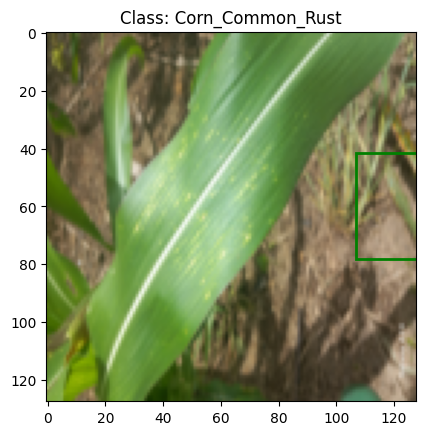

Index 1, Image ID: id_g7ihqb.jpg
Original BBox: [1791.5014164305949, 976.4140748031496, 1872.407932011332, 1057.371555]
Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([0.9331, 0.9041, 0.9752, 0.9790]), Label=0


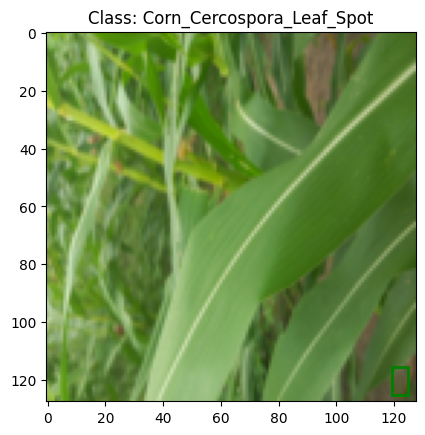

Index 2, Image ID: id_bexuks.jpg
Original BBox: [1515.147633358377, 498.0424599198397, 2154.2710368144253, 906.0589929859718]
Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([0.7891, 0.4612, 1.0000, 0.8389]), Label=17


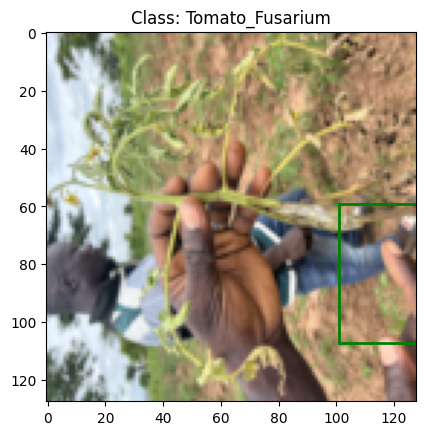

Index 3, Image ID: id_61rxsc.jpg
Original BBox: [632.3927239, 1207.9094701405152, 749.9160447761194, 1324.9353227459017]
Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([0.3294, 1.0000, 0.3906, 1.0000]), Label=16


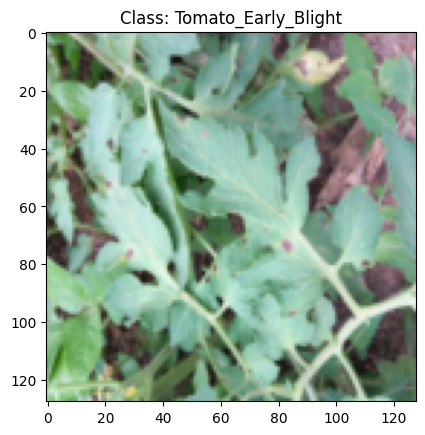

Index 4, Image ID: id_gx31o5.jpg
Original BBox: [592.2619271224643, 360.5100826653307, 841.8975394, 871.1528525801604]
Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([0.3085, 0.3338, 0.4385, 0.8066]), Label=16


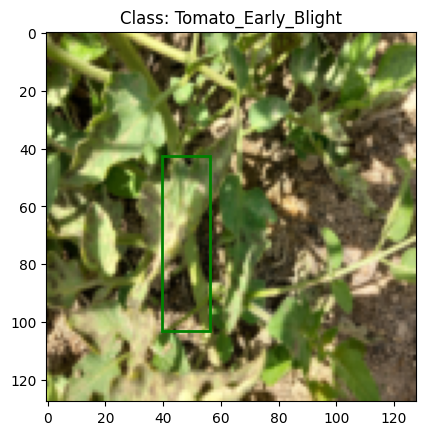

Using 0 workers for DataLoader.
CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_layers): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc_bbox): Sequent

Training:   0%|          | 0/193 [00:00<?, ?it/s]

Index 2, Image ID: id_bexuks.jpg
Original BBox: [1515.147633358377, 498.0424599198397, 2154.2710368144253, 906.0589929859718]
Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([0.7891, 0.4612, 1.0000, 0.8389]), Label=17


Training:   1%|          | 1/193 [00:02<08:06,  2.54s/it, IoU Loss=1.0000, Class Loss=3.1393]

Predicted BBoxes (first 1): tensor([0.4958, 0.5010, 0.5122, 0.4915], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.3895, 0.2026, 0.5393, 0.3919], device='cuda:0')


Training:   4%|▍         | 8/193 [00:03<00:44,  4.17it/s, IoU Loss=0.9982, Class Loss=3.0912]

Index 3, Image ID: id_61rxsc.jpg
Original BBox: [632.3927239, 1207.9094701405152, 749.9160447761194, 1324.9353227459017]
Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([0.3294, 1.0000, 0.3906, 1.0000]), Label=16


Training:   6%|▌         | 12/193 [00:04<00:31,  5.69it/s, IoU Loss=0.9997, Class Loss=3.0079]

Predicted BBoxes (first 1): tensor([0.4719, 0.4607, 0.5312, 0.5205], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.3380, 1.0000, 0.5461], device='cuda:0')


Training:  10%|▉         | 19/193 [00:05<00:27,  6.23it/s, IoU Loss=0.9837, Class Loss=2.7159]

Index 4, Image ID: id_gx31o5.jpg
Original BBox: [592.2619271224643, 360.5100826653307, 841.8975394, 871.1528525801604]
Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([0.3085, 0.3338, 0.4385, 0.8066]), Label=16


Training:  11%|█▏        | 22/193 [00:06<00:26,  6.49it/s, IoU Loss=0.9954, Class Loss=2.7035]

Predicted BBoxes (first 1): tensor([0.3625, 0.2781, 0.6685, 0.8296], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4070, 0.4948, 0.4536, 0.5321], device='cuda:0')


Training:  17%|█▋        | 32/193 [00:07<00:25,  6.31it/s, IoU Loss=0.9820, Class Loss=2.3380]

Predicted BBoxes (first 1): tensor([0.4812, 0.4768, 0.6489, 0.8633], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  19%|█▉        | 37/193 [00:08<00:23,  6.56it/s, IoU Loss=0.9845, Class Loss=2.1599]

Index 9, Image ID: id_inj1z5.jpg
Original BBox: [1673.3278508771923, 2514.035087719298, 1881.9901315789468, 2851.644736842105]
Fetched index 9: Image_ID=id_inj1z5.jpg, BBox=tensor([0.8715, 1.0000, 0.9802, 1.0000]), Label=19


Training:  22%|██▏       | 42/193 [00:09<00:24,  6.19it/s, IoU Loss=0.9771, Class Loss=2.1870]

Predicted BBoxes (first 1): tensor([0.3005, 0.5137, 0.7256, 0.9658], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  27%|██▋       | 52/193 [00:10<00:21,  6.44it/s, IoU Loss=0.9869, Class Loss=2.1042]

Predicted BBoxes (first 1): tensor([0.2832, 0.5010, 0.7979, 0.9087], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.9103, 1.0000, 1.0000], device='cuda:0')


Training:  32%|███▏      | 62/193 [00:12<00:19,  6.76it/s, IoU Loss=0.9775, Class Loss=2.2142]

Predicted BBoxes (first 1): tensor([0.3687, 0.4670, 0.8540, 0.9932], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6430, 0.1365, 0.6817, 0.2616], device='cuda:0')


Training:  35%|███▌      | 68/193 [00:13<00:17,  7.02it/s, IoU Loss=0.9844, Class Loss=2.1791]

Index 1, Image ID: id_g7ihqb.jpg
Original BBox: [1791.5014164305949, 976.4140748031496, 1872.407932011332, 1057.371555]
Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([0.9331, 0.9041, 0.9752, 0.9790]), Label=0


Training:  37%|███▋      | 72/193 [00:13<00:17,  6.78it/s, IoU Loss=0.9850, Class Loss=2.1660]

Predicted BBoxes (first 1): tensor([0.5293, 0.3655, 0.9141, 0.9976], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4646, 0.5339, 0.5306, 0.5850], device='cuda:0')


Training:  42%|████▏     | 81/193 [00:15<00:16,  6.70it/s, IoU Loss=0.9936, Class Loss=2.0795]

Index 7, Image ID: id_wdx8a2.jpg
Original BBox: [2184.810475534114, 915.1444295558958, 2316.9676085458304, 996.6819486983154]
Fetched index 7: Image_ID=id_wdx8a2.jpg, BBox=tensor([1.0000, 0.8474, 1.0000, 0.9229]), Label=0
Predicted BBoxes (first 1): tensor([0.4390, 0.3074, 0.9565, 0.9990], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.2662, 0.4850, 0.2962, 0.6261], device='cuda:0')


Training:  47%|████▋     | 91/193 [00:16<00:15,  6.44it/s, IoU Loss=0.9823, Class Loss=1.8613]

Index 5, Image ID: id_8puhgc.jpg
Original BBox: [2669.587171052632, 1339.3930921052631, 2822.824835526316, 1497.6776315789473]
Fetched index 5: Image_ID=id_8puhgc.jpg, BBox=tensor([1., 1., 1., 1.]), Label=13
Predicted BBoxes (first 1): tensor([0.2430, 0.3318, 0.9468, 0.9922], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')
Index 0, Image ID: id_3dezub.jpg
Original BBox: [1599.944865609924, 350.00507274119445, 2100.4548587181253, 659.2853177641653]
Fetched index 0: Image_ID=id_3dezub.jpg, BBox=tensor([0.8333, 0.3241, 1.0000, 0.6104]), Label=1


Training:  53%|█████▎    | 102/193 [00:18<00:13,  6.99it/s, IoU Loss=0.9890, Class Loss=2.0241]

Predicted BBoxes (first 1): tensor([0.3416, 0.2401, 0.9980, 0.9995], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.8526, 1.0000, 0.9567], device='cuda:0')


Training:  54%|█████▍    | 104/193 [00:18<00:13,  6.61it/s, IoU Loss=0.9772, Class Loss=1.6736]

Index 6, Image ID: id_t5sgaw.jpg
Original BBox: [2268.638993238167, 771.9078156312625, 2685.404583020286, 1322.3963552104208]
Fetched index 6: Image_ID=id_t5sgaw.jpg, BBox=tensor([1.0000, 0.7147, 1.0000, 1.0000]), Label=22


Training:  58%|█████▊    | 112/193 [00:19<00:12,  6.30it/s, IoU Loss=0.9849, Class Loss=2.0375]

Predicted BBoxes (first 1): tensor([0.3708, 0.4116, 0.9873, 0.9941], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.9092, 0.9788, 0.9505, 1.0000], device='cuda:0')


Training:  63%|██████▎   | 122/193 [00:21<00:11,  6.15it/s, IoU Loss=0.9668, Class Loss=1.6793]

Predicted BBoxes (first 1): tensor([0.5254, 0.5586, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.9197, 0.7953, 1.0000, 1.0000], device='cuda:0')


Training:  68%|██████▊   | 132/193 [00:22<00:09,  6.54it/s, IoU Loss=0.9906, Class Loss=1.6677]

Predicted BBoxes (first 1): tensor([0.3782, 0.3628, 0.9780, 0.9966], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.1683, 0.2879, 0.1795, 0.3157], device='cuda:0')


Training:  74%|███████▎  | 142/193 [00:24<00:07,  6.68it/s, IoU Loss=0.9914, Class Loss=1.5748]

Predicted BBoxes (first 1): tensor([0.2021, 0.8916, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6166, 1.0000, 1.0000, 1.0000], device='cuda:0')


Training:  79%|███████▉  | 152/193 [00:26<00:06,  6.46it/s, IoU Loss=0.9882, Class Loss=1.1808]

Predicted BBoxes (first 1): tensor([0.1780, 0.3347, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6180, 0.2252, 0.9607, 0.4673], device='cuda:0')


Training:  81%|████████▏ | 157/193 [00:26<00:05,  6.44it/s, IoU Loss=0.9796, Class Loss=1.4057]

Index 8, Image ID: id_rongu5.jpg
Original BBox: [2311.4988730277987, 1849.342747995992, 2368.523102930128, 1930.5980711422844]
Fetched index 8: Image_ID=id_rongu5.jpg, BBox=tensor([1., 1., 1., 1.]), Label=22


Training:  84%|████████▍ | 162/193 [00:27<00:04,  6.36it/s, IoU Loss=0.9961, Class Loss=1.4243]

Predicted BBoxes (first 1): tensor([0.6177, 0.6489, 0.9961, 0.9995], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6748, 0.5465, 0.7852, 0.7072], device='cuda:0')


Training:  89%|████████▉ | 172/193 [00:29<00:03,  6.48it/s, IoU Loss=0.9755, Class Loss=1.2620]

Predicted BBoxes (first 1): tensor([0.3955, 0.4263, 0.9980, 0.9990], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4641, 0.2233, 0.6803, 0.6286], device='cuda:0')


Training:  94%|█████████▍| 182/193 [00:30<00:01,  6.72it/s, IoU Loss=0.9823, Class Loss=1.2701]

Predicted BBoxes (first 1): tensor([0.1718, 0.2351, 0.9985, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.0029, 1.0000, 0.1348, 1.0000], device='cuda:0')


Training:  99%|█████████▉| 192/193 [00:32<00:00,  6.78it/s, IoU Loss=0.9881, Class Loss=1.3135]

Predicted BBoxes (first 1): tensor([0.3284, 0.4636, 0.9985, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training Losses -> IoU Loss: 0.9866, Class Loss: 1.9259

=== Validation After Epoch 1 ===


Validation Classification:   2%|▏         | 1/49 [00:00<00:07,  6.25it/s]

Index 0, Image ID: id_mn4tn2.jpg
Original BBox: [883.8354037267079, 1097.4999999999998, 924.7049689440992, 1176.7753623188405]
Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([0.4603, 1.0000, 0.4816, 1.0000]), Label=19
Index 1, Image ID: id_tpwp5j.jpg
Original BBox: [3520.5590551181103, 1555.8868144690782, 3941.248031496063, 1940.5580513418904]
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([1., 1., 1., 1.]), Label=4
Index 2, Image ID: id_9bfxvd.jpg
Original BBox: [1867.505241090147, 316.40887034161494, 1958.742138, 381.9802989130435]
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([0.9727, 0.2930, 1.0000, 0.3537]), Label=0
Index 3, Image ID: id_nqu6ez.jpg
Original BBox: [1056.4014373716632, 421.75051334702255, 1120.6673511293634, 439.5020533880903]
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([0.5502, 0.3905, 0.5837, 0.4069]), Label=6
Index 4, Image ID: id_yvbi4o.jpg
Original BBox: [2518.331517655898, 1974.9008642284568, 2582.609504132232, 2036.9342434869736]
F


--- Classification Evaluation ---
Accuracy: 0.6045
Precision (Weighted): 0.6412
Recall (Weighted): 0.6045
F1-Score (Weighted): 0.5843
Confusion Matrix:
[[833   1  68   0  43   2   0   0   0  14   0   0   7   7   0   0   8   0
    1   4   0   0   0]
 [160  34  33   0   9   1   0   0   2   1   0   0   0   7   0   0   0   0
    1   0   0   0   0]
 [ 75   0 136   0   3   1   0   0   0  15   0   0   0   1   0   0   0   0
    0   0   0   0   0]
 [  3   0   0   0  18   0   0   0   0   0   0   0   0   2   0   0   1   0
    0   0   0   0   2]
 [  3   0   1   0 423   2   0   0   0  15   0   0   4   3   0   0   9   0
    2   3   0   0  10]
 [  3   0   1   0  11 110   0   0   0  44   0   0   8  49   1   0   3   2
   26   4   0   0  32]
 [  6   0   0   0   7   1   4   0   2   8   0   0   5  13   0   0   4   1
   13   1   0   0   5]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   6   0
    2   0   0   0   9]
 [  0   0   0   0   0   5   0   0  12  16   0   0   4  10   0   0   2  

Validation Bounding Boxes:   2%|▏         | 1/49 [00:00<00:06,  7.97it/s]

Index 0, Image ID: id_mn4tn2.jpg
Original BBox: [883.8354037267079, 1097.4999999999998, 924.7049689440992, 1176.7753623188405]
Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([0.4603, 1.0000, 0.4816, 1.0000]), Label=19
Index 1, Image ID: id_tpwp5j.jpg
Original BBox: [3520.5590551181103, 1555.8868144690782, 3941.248031496063, 1940.5580513418904]
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([1., 1., 1., 1.]), Label=4
Index 2, Image ID: id_9bfxvd.jpg
Original BBox: [1867.505241090147, 316.40887034161494, 1958.742138, 381.9802989130435]
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([0.9727, 0.2930, 1.0000, 0.3537]), Label=0
Index 3, Image ID: id_nqu6ez.jpg
Original BBox: [1056.4014373716632, 421.75051334702255, 1120.6673511293634, 439.5020533880903]
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([0.5502, 0.3905, 0.5837, 0.4069]), Label=6
Index 4, Image ID: id_yvbi4o.jpg
Original BBox: [2518.331517655898, 1974.9008642284568, 2582.609504132232, 2036.9342434869736]
F


--- Bounding Box Evaluation ---
Mean IoU: 0.0162
Precision at IoU >= 0.5: 0.0058
Checkpoint saved to 'custom_cnn_model_epoch_1.pth'

=== Epoch 2/10 ===


Training:   1%|          | 2/193 [00:00<00:36,  5.28it/s, IoU Loss=0.9946, Class Loss=1.0959]

Predicted BBoxes (first 1): tensor([0.1082, 0.2407, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6423, 1.0000, 0.8271, 1.0000], device='cuda:0')


Training:   6%|▌         | 12/193 [00:02<00:30,  5.94it/s, IoU Loss=0.9884, Class Loss=1.1850]

Predicted BBoxes (first 1): tensor([0.0862, 0.2372, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4280, 1.0000, 0.6246, 1.0000], device='cuda:0')


Training:  11%|█▏        | 22/193 [00:03<00:25,  6.77it/s, IoU Loss=0.9816, Class Loss=1.2123]

Predicted BBoxes (first 1): tensor([0.5562, 0.5117, 0.9976, 0.9995], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.2438, 0.1307, 0.2849, 0.1626], device='cuda:0')


Training:  12%|█▏        | 23/193 [00:03<00:25,  6.57it/s, IoU Loss=0.9894, Class Loss=1.3052]

Index 1, Image ID: id_g7ihqb.jpg
Original BBox: [1791.5014164305949, 976.4140748031496, 1872.407932011332, 1057.371555]
Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([0.9331, 0.9041, 0.9752, 0.9790]), Label=0


Training:  17%|█▋        | 32/193 [00:04<00:23,  6.74it/s, IoU Loss=0.9922, Class Loss=0.9382]

Predicted BBoxes (first 1): tensor([0.1886, 0.4487, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  21%|██        | 40/193 [00:06<00:22,  6.95it/s, IoU Loss=0.9765, Class Loss=1.0079]

Index 6, Image ID: id_t5sgaw.jpg
Original BBox: [2268.638993238167, 771.9078156312625, 2685.404583020286, 1322.3963552104208]
Fetched index 6: Image_ID=id_t5sgaw.jpg, BBox=tensor([1.0000, 0.7147, 1.0000, 1.0000]), Label=22


Training:  22%|██▏       | 42/193 [00:06<00:21,  6.94it/s, IoU Loss=0.9725, Class Loss=1.0683]

Predicted BBoxes (first 1): tensor([0.2869, 0.4197, 0.9980, 0.9995], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.1874, 0.1884, 0.2042, 0.2166], device='cuda:0')


Training:  27%|██▋       | 52/193 [00:07<00:20,  6.99it/s, IoU Loss=0.9905, Class Loss=0.8899]

Predicted BBoxes (first 1): tensor([0.3931, 0.3884, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4788, 0.6417, 0.4994, 0.6856], device='cuda:0')


Training:  32%|███▏      | 62/193 [00:09<00:19,  6.86it/s, IoU Loss=0.9872, Class Loss=0.9275]

Predicted BBoxes (first 1): tensor([0.1542, 0.4685, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')
Index 3, Image ID: id_61rxsc.jpg
Original BBox: [632.3927239, 1207.9094701405152, 749.9160447761194, 1324.9353227459017]
Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([0.3294, 1.0000, 0.3906, 1.0000]), Label=16


Training:  37%|███▋      | 72/193 [00:10<00:17,  6.76it/s, IoU Loss=0.9836, Class Loss=0.9933]

Predicted BBoxes (first 1): tensor([0.7026, 0.4631, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.4412, 1.0000, 0.5688], device='cuda:0')


Training:  40%|███▉      | 77/193 [00:11<00:16,  6.96it/s, IoU Loss=0.9849, Class Loss=0.8163]

Index 0, Image ID: id_3dezub.jpg
Original BBox: [1599.944865609924, 350.00507274119445, 2100.4548587181253, 659.2853177641653]
Fetched index 0: Image_ID=id_3dezub.jpg, BBox=tensor([0.8333, 0.3241, 1.0000, 0.6104]), Label=1


Training:  42%|████▏     | 82/193 [00:12<00:15,  7.08it/s, IoU Loss=0.9843, Class Loss=0.8241]

Predicted BBoxes (first 1): tensor([0.2830, 0.7471, 0.9985, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.3976, 0.5375, 0.4380, 0.6043], device='cuda:0')


Training:  46%|████▌     | 88/193 [00:12<00:14,  7.10it/s, IoU Loss=0.9870, Class Loss=0.9720]

Index 5, Image ID: id_8puhgc.jpg
Original BBox: [2669.587171052632, 1339.3930921052631, 2822.824835526316, 1497.6776315789473]
Fetched index 5: Image_ID=id_8puhgc.jpg, BBox=tensor([1., 1., 1., 1.]), Label=13


Training:  48%|████▊     | 92/193 [00:13<00:14,  7.20it/s, IoU Loss=0.9851, Class Loss=0.7937]

Predicted BBoxes (first 1): tensor([0.1575, 0.2225, 0.9985, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.5226, 0.5850, 0.5672, 0.6525], device='cuda:0')


Training:  51%|█████     | 98/193 [00:14<00:13,  6.98it/s, IoU Loss=0.9783, Class Loss=0.7219]

Index 2, Image ID: id_bexuks.jpg
Original BBox: [1515.147633358377, 498.0424599198397, 2154.2710368144253, 906.0589929859718]
Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([0.7891, 0.4612, 1.0000, 0.8389]), Label=17


Training:  53%|█████▎    | 102/193 [00:14<00:12,  7.22it/s, IoU Loss=0.9897, Class Loss=0.8540]

Predicted BBoxes (first 1): tensor([0.2668, 0.4812, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.5878, 0.1615, 0.6659, 0.2454], device='cuda:0')
Index 4, Image ID: id_gx31o5.jpg
Original BBox: [592.2619271224643, 360.5100826653307, 841.8975394, 871.1528525801604]
Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([0.3085, 0.3338, 0.4385, 0.8066]), Label=16


Training:  58%|█████▊    | 112/193 [00:16<00:12,  6.65it/s, IoU Loss=0.9917, Class Loss=0.8308]

Predicted BBoxes (first 1): tensor([0.0729, 0.2849, 0.9966, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.9292, 1.0000, 1.0000], device='cuda:0')


Training:  63%|██████▎   | 122/193 [00:17<00:10,  7.03it/s, IoU Loss=0.9901, Class Loss=0.8810]

Predicted BBoxes (first 1): tensor([0.3496, 0.3411, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  68%|██████▊   | 132/193 [00:19<00:08,  7.15it/s, IoU Loss=0.9771, Class Loss=0.6677]

Predicted BBoxes (first 1): tensor([0.1118, 0.3215, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4442, 0.4666, 0.5870, 0.9023], device='cuda:0')


Training:  74%|███████▎  | 142/193 [00:20<00:07,  7.06it/s, IoU Loss=0.9886, Class Loss=0.9090]

Predicted BBoxes (first 1): tensor([0.2800, 0.7905, 0.9971, 0.9995], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4932, 0.4622, 0.5235, 0.5566], device='cuda:0')


Training:  79%|███████▉  | 152/193 [00:22<00:06,  6.82it/s, IoU Loss=0.9724, Class Loss=0.7800]

Predicted BBoxes (first 1): tensor([0.5601, 0.5171, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4978, 1.0000, 0.5792, 1.0000], device='cuda:0')
Index 7, Image ID: id_wdx8a2.jpg
Original BBox: [2184.810475534114, 915.1444295558958, 2316.9676085458304, 996.6819486983154]
Fetched index 7: Image_ID=id_wdx8a2.jpg, BBox=tensor([1.0000, 0.8474, 1.0000, 0.9229]), Label=0


Training:  82%|████████▏ | 158/193 [00:22<00:04,  7.05it/s, IoU Loss=0.9833, Class Loss=0.6054]

Index 9, Image ID: id_inj1z5.jpg
Original BBox: [1673.3278508771923, 2514.035087719298, 1881.9901315789468, 2851.644736842105]
Fetched index 9: Image_ID=id_inj1z5.jpg, BBox=tensor([0.8715, 1.0000, 0.9802, 1.0000]), Label=19


Training:  84%|████████▍ | 162/193 [00:23<00:04,  7.15it/s, IoU Loss=0.9927, Class Loss=0.7202]

Predicted BBoxes (first 1): tensor([0.6069, 0.2542, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.5524, 1.0000, 0.7077, 1.0000], device='cuda:0')


Training:  87%|████████▋ | 167/193 [00:24<00:03,  6.99it/s, IoU Loss=0.9697, Class Loss=0.6283]

Index 8, Image ID: id_rongu5.jpg
Original BBox: [2311.4988730277987, 1849.342747995992, 2368.523102930128, 1930.5980711422844]
Fetched index 8: Image_ID=id_rongu5.jpg, BBox=tensor([1., 1., 1., 1.]), Label=22


Training:  89%|████████▉ | 172/193 [00:24<00:02,  7.09it/s, IoU Loss=0.9928, Class Loss=0.5950]

Predicted BBoxes (first 1): tensor([0.7017, 0.4783, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  94%|█████████▍| 182/193 [00:26<00:01,  7.10it/s, IoU Loss=0.9857, Class Loss=0.6219]

Predicted BBoxes (first 1): tensor([0.4150, 0.3931, 0.9961, 0.9995], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.1192, 0.5228, 0.1450, 0.5902], device='cuda:0')


Training:  99%|█████████▉| 192/193 [00:27<00:00,  7.13it/s, IoU Loss=0.9965, Class Loss=0.8488]

Predicted BBoxes (first 1): tensor([0.2195, 0.3206, 0.9990, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training Losses -> IoU Loss: 0.9847, Class Loss: 0.8757

=== Validation After Epoch 2 ===


Validation Classification:   2%|▏         | 1/49 [00:00<00:05,  9.22it/s]

Index 0, Image ID: id_mn4tn2.jpg
Original BBox: [883.8354037267079, 1097.4999999999998, 924.7049689440992, 1176.7753623188405]
Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([0.4603, 1.0000, 0.4816, 1.0000]), Label=19
Index 1, Image ID: id_tpwp5j.jpg
Original BBox: [3520.5590551181103, 1555.8868144690782, 3941.248031496063, 1940.5580513418904]
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([1., 1., 1., 1.]), Label=4
Index 2, Image ID: id_9bfxvd.jpg
Original BBox: [1867.505241090147, 316.40887034161494, 1958.742138, 381.9802989130435]
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([0.9727, 0.2930, 1.0000, 0.3537]), Label=0
Index 3, Image ID: id_nqu6ez.jpg
Original BBox: [1056.4014373716632, 421.75051334702255, 1120.6673511293634, 439.5020533880903]
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([0.5502, 0.3905, 0.5837, 0.4069]), Label=6
Index 4, Image ID: id_yvbi4o.jpg
Original BBox: [2518.331517655898, 1974.9008642284568, 2582.609504132232, 2036.9342434869736]
F


--- Classification Evaluation ---
Accuracy: 0.7560
Precision (Weighted): 0.7859
Recall (Weighted): 0.7560
F1-Score (Weighted): 0.7562
Confusion Matrix:
[[718 189  30   0  31   6   0   0   0   0   0   0   7   7   0   0   0   0
    0   0   0   0   0]
 [ 31 207   4   0   2   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [ 23   5 191   0   3   0   0   0   0   0   0   0   2   7   0   0   0   0
    0   0   0   0   0]
 [  3   3   0   0  18   0   0   0   0   2   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  5   8   1   0 449   4   0   0   0   0   0   1   0   7   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   2 251   0   0   0   7   0   1   7  17   1   0   3   0
    1   1   0   0   3]
 [  0   0   0   0   0   6  41   0   0   1   0   0  11   6   1   0   0   0
    3   0   0   0   1]
 [  0   0   0   0   0   0   0  16   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1]
 [  0   0   0   0   0   7   1   0  37   6   0   2   7   5   2   0   0  

Validation Bounding Boxes:   2%|▏         | 1/49 [00:00<00:06,  7.96it/s]

Index 0, Image ID: id_mn4tn2.jpg
Original BBox: [883.8354037267079, 1097.4999999999998, 924.7049689440992, 1176.7753623188405]
Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([0.4603, 1.0000, 0.4816, 1.0000]), Label=19
Index 1, Image ID: id_tpwp5j.jpg
Original BBox: [3520.5590551181103, 1555.8868144690782, 3941.248031496063, 1940.5580513418904]
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([1., 1., 1., 1.]), Label=4
Index 2, Image ID: id_9bfxvd.jpg
Original BBox: [1867.505241090147, 316.40887034161494, 1958.742138, 381.9802989130435]
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([0.9727, 0.2930, 1.0000, 0.3537]), Label=0
Index 3, Image ID: id_nqu6ez.jpg
Original BBox: [1056.4014373716632, 421.75051334702255, 1120.6673511293634, 439.5020533880903]
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([0.5502, 0.3905, 0.5837, 0.4069]), Label=6
Index 4, Image ID: id_yvbi4o.jpg
Original BBox: [2518.331517655898, 1974.9008642284568, 2582.609504132232, 2036.9342434869736]
F


--- Bounding Box Evaluation ---
Mean IoU: 0.0161
Precision at IoU >= 0.5: 0.0058
Checkpoint saved to 'custom_cnn_model_epoch_2.pth'

=== Epoch 3/10 ===


Training:   1%|          | 2/193 [00:00<00:37,  5.08it/s, IoU Loss=0.9905, Class Loss=0.6781]

Predicted BBoxes (first 1): tensor([0.3220, 0.3228, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.1245, 0.5870, 0.8714, 1.0000], device='cuda:0')


Training:   6%|▌         | 12/193 [00:01<00:26,  6.75it/s, IoU Loss=0.9893, Class Loss=0.6193]

Predicted BBoxes (first 1): tensor([0.3777, 0.4294, 0.9980, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:   7%|▋         | 14/193 [00:02<00:26,  6.78it/s, IoU Loss=0.9861, Class Loss=0.5426]

Index 5, Image ID: id_8puhgc.jpg
Original BBox: [2669.587171052632, 1339.3930921052631, 2822.824835526316, 1497.6776315789473]
Fetched index 5: Image_ID=id_8puhgc.jpg, BBox=tensor([1., 1., 1., 1.]), Label=13


Training:  11%|█▏        | 22/193 [00:03<00:24,  7.04it/s, IoU Loss=0.9849, Class Loss=0.5074]

Predicted BBoxes (first 1): tensor([0.3440, 0.0998, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.2720, 1.0000, 0.4146, 1.0000], device='cuda:0')


Training:  17%|█▋        | 32/193 [00:04<00:23,  6.87it/s, IoU Loss=0.9905, Class Loss=0.5802]

Predicted BBoxes (first 1): tensor([0.4492, 0.4617, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.8744, 0.4974, 0.9963, 0.6701], device='cuda:0')


Training:  22%|██▏       | 42/193 [00:06<00:21,  6.99it/s, IoU Loss=0.9784, Class Loss=0.7064]

Predicted BBoxes (first 1): tensor([0.1318, 0.4634, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.5870, 1.0000, 0.6807], device='cuda:0')


Training:  23%|██▎       | 44/193 [00:06<00:21,  7.09it/s, IoU Loss=0.9841, Class Loss=0.7465]

Index 8, Image ID: id_rongu5.jpg
Original BBox: [2311.4988730277987, 1849.342747995992, 2368.523102930128, 1930.5980711422844]
Fetched index 8: Image_ID=id_rongu5.jpg, BBox=tensor([1., 1., 1., 1.]), Label=22


Training:  27%|██▋       | 52/193 [00:07<00:20,  6.99it/s, IoU Loss=0.9825, Class Loss=0.5368]

Predicted BBoxes (first 1): tensor([0.3049, 0.8188, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.4855, 1.0000, 1.0000], device='cuda:0')


Training:  32%|███▏      | 62/193 [00:09<00:18,  7.09it/s, IoU Loss=0.9912, Class Loss=0.5631]

Predicted BBoxes (first 1): tensor([0.3591, 0.3574, 0.9956, 0.9995], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4745, 0.6355, 0.4963, 0.6822], device='cuda:0')


Training:  36%|███▋      | 70/193 [00:10<00:18,  6.76it/s, IoU Loss=0.9769, Class Loss=0.4162]

Index 3, Image ID: id_61rxsc.jpg
Original BBox: [632.3927239, 1207.9094701405152, 749.9160447761194, 1324.9353227459017]
Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([0.3294, 1.0000, 0.3906, 1.0000]), Label=16


Training:  37%|███▋      | 72/193 [00:10<00:18,  6.68it/s, IoU Loss=0.9859, Class Loss=0.5369]

Predicted BBoxes (first 1): tensor([0.5195, 0.4282, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4148, 0.4888, 0.4596, 0.5713], device='cuda:0')


Training:  42%|████▏     | 82/193 [00:12<00:16,  6.75it/s, IoU Loss=0.9902, Class Loss=0.5750]

Predicted BBoxes (first 1): tensor([0.6538, 0.5732, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.4751, 1.0000, 0.5649], device='cuda:0')


Training:  46%|████▌     | 88/193 [00:12<00:15,  6.79it/s, IoU Loss=0.9751, Class Loss=0.6163]

Index 6, Image ID: id_t5sgaw.jpg
Original BBox: [2268.638993238167, 771.9078156312625, 2685.404583020286, 1322.3963552104208]
Fetched index 6: Image_ID=id_t5sgaw.jpg, BBox=tensor([1.0000, 0.7147, 1.0000, 1.0000]), Label=22


Training:  48%|████▊     | 92/193 [00:13<00:14,  6.92it/s, IoU Loss=0.9792, Class Loss=0.6046]

Predicted BBoxes (first 1): tensor([0.1172, 0.1190, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  53%|█████▎    | 102/193 [00:14<00:13,  6.91it/s, IoU Loss=0.9879, Class Loss=0.5959]

Predicted BBoxes (first 1): tensor([0.3032, 0.0906, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.9981, 1.0000, 1.0000], device='cuda:0')


Training:  58%|█████▊    | 111/193 [00:16<00:12,  6.46it/s, IoU Loss=0.9801, Class Loss=0.5809]

Index 0, Image ID: id_3dezub.jpg
Original BBox: [1599.944865609924, 350.00507274119445, 2100.4548587181253, 659.2853177641653]
Fetched index 0: Image_ID=id_3dezub.jpg, BBox=tensor([0.8333, 0.3241, 1.0000, 0.6104]), Label=1
Predicted BBoxes (first 1): tensor([0.1852, 0.5376, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.9978, 1.0000, 1.0000], device='cuda:0')


Training:  59%|█████▊    | 113/193 [00:16<00:12,  6.63it/s, IoU Loss=0.9726, Class Loss=0.5012]

Index 7, Image ID: id_wdx8a2.jpg
Original BBox: [2184.810475534114, 915.1444295558958, 2316.9676085458304, 996.6819486983154]
Fetched index 7: Image_ID=id_wdx8a2.jpg, BBox=tensor([1.0000, 0.8474, 1.0000, 0.9229]), Label=0


Training:  63%|██████▎   | 122/193 [00:17<00:10,  6.93it/s, IoU Loss=0.9687, Class Loss=0.5460]

Predicted BBoxes (first 1): tensor([0.4778, 0.4692, 0.9990, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.8762, 1.0000, 0.9454], device='cuda:0')


Training:  66%|██████▌   | 127/193 [00:18<00:09,  6.71it/s, IoU Loss=0.9909, Class Loss=0.5021]

Index 9, Image ID: id_inj1z5.jpg
Original BBox: [1673.3278508771923, 2514.035087719298, 1881.9901315789468, 2851.644736842105]
Fetched index 9: Image_ID=id_inj1z5.jpg, BBox=tensor([0.8715, 1.0000, 0.9802, 1.0000]), Label=19


Training:  68%|██████▊   | 132/193 [00:19<00:08,  6.93it/s, IoU Loss=0.9824, Class Loss=0.5708]

Predicted BBoxes (first 1): tensor([0.1567, 0.1072, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.7969, 0.5476, 0.8383, 0.6059], device='cuda:0')


Training:  74%|███████▎  | 142/193 [00:20<00:07,  6.63it/s, IoU Loss=0.9863, Class Loss=0.5730]

Predicted BBoxes (first 1): tensor([0.7065, 0.3250, 0.9985, 0.9995], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6868, 1.0000, 0.7765, 1.0000], device='cuda:0')


Training:  79%|███████▉  | 152/193 [00:22<00:06,  6.78it/s, IoU Loss=0.9855, Class Loss=0.6012]

Predicted BBoxes (first 1): tensor([0.8711, 0.3291, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.7276, 1.0000, 1.0000], device='cuda:0')


Training:  82%|████████▏ | 159/193 [00:23<00:05,  6.76it/s, IoU Loss=0.9789, Class Loss=0.4854]

Index 4, Image ID: id_gx31o5.jpg
Original BBox: [592.2619271224643, 360.5100826653307, 841.8975394, 871.1528525801604]
Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([0.3085, 0.3338, 0.4385, 0.8066]), Label=16
Index 2, Image ID: id_bexuks.jpg
Original BBox: [1515.147633358377, 498.0424599198397, 2154.2710368144253, 906.0589929859718]
Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([0.7891, 0.4612, 1.0000, 0.8389]), Label=17


Training:  84%|████████▍ | 162/193 [00:23<00:04,  6.84it/s, IoU Loss=0.9859, Class Loss=0.5131]

Predicted BBoxes (first 1): tensor([0.1103, 0.2764, 0.9976, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4017, 0.4779, 0.4304, 0.5346], device='cuda:0')


Training:  89%|████████▉ | 172/193 [00:25<00:03,  6.87it/s, IoU Loss=0.9779, Class Loss=0.5743]

Predicted BBoxes (first 1): tensor([0.1267, 0.4153, 0.9980, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')
Index 1, Image ID: id_g7ihqb.jpg
Original BBox: [1791.5014164305949, 976.4140748031496, 1872.407932011332, 1057.371555]
Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([0.9331, 0.9041, 0.9752, 0.9790]), Label=0


Training:  94%|█████████▍| 182/193 [00:26<00:01,  7.00it/s, IoU Loss=0.9856, Class Loss=0.5644]

Predicted BBoxes (first 1): tensor([0.2440, 0.7212, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4630, 1.0000, 0.8466, 1.0000], device='cuda:0')


Training:  99%|█████████▉| 192/193 [00:28<00:00,  7.01it/s, IoU Loss=0.9929, Class Loss=0.4109]

Predicted BBoxes (first 1): tensor([0.0862, 0.6899, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.7888, 0.7747, 0.8064, 0.8127], device='cuda:0')


Training Losses -> IoU Loss: 0.9841, Class Loss: 0.5686

=== Validation After Epoch 3 ===


Validation Classification:   2%|▏         | 1/49 [00:00<00:06,  7.63it/s]

Index 0, Image ID: id_mn4tn2.jpg
Original BBox: [883.8354037267079, 1097.4999999999998, 924.7049689440992, 1176.7753623188405]
Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([0.4603, 1.0000, 0.4816, 1.0000]), Label=19
Index 1, Image ID: id_tpwp5j.jpg
Original BBox: [3520.5590551181103, 1555.8868144690782, 3941.248031496063, 1940.5580513418904]
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([1., 1., 1., 1.]), Label=4
Index 2, Image ID: id_9bfxvd.jpg
Original BBox: [1867.505241090147, 316.40887034161494, 1958.742138, 381.9802989130435]
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([0.9727, 0.2930, 1.0000, 0.3537]), Label=0
Index 3, Image ID: id_nqu6ez.jpg
Original BBox: [1056.4014373716632, 421.75051334702255, 1120.6673511293634, 439.5020533880903]
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([0.5502, 0.3905, 0.5837, 0.4069]), Label=6
Index 4, Image ID: id_yvbi4o.jpg
Original BBox: [2518.331517655898, 1974.9008642284568, 2582.609504132232, 2036.9342434869736]
F


--- Classification Evaluation ---
Accuracy: 0.7913
Precision (Weighted): 0.7980
Recall (Weighted): 0.7913
F1-Score (Weighted): 0.7889
Confusion Matrix:
[[886  62  16   0  24   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [ 72 170   2   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [ 47   5 177   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  4   2   0   6  14   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [ 18   1   0   9 447   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   2 269   0   0   0   5   0   2   2  13   0   0   0   0
    0   0   0   0   1]
 [  0   0   0   0   0   5  43   0   0   2   0   4  11   2   0   0   0   0
    3   0   0   0   0]
 [  0   0   0   0   0   0   0   9   0   0   0   0   0   0   0   0   8   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   2   0  50   6   0   1   2   6   0   0   0  

Validation Bounding Boxes:   2%|▏         | 1/49 [00:00<00:06,  7.97it/s]

Index 0, Image ID: id_mn4tn2.jpg
Original BBox: [883.8354037267079, 1097.4999999999998, 924.7049689440992, 1176.7753623188405]
Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([0.4603, 1.0000, 0.4816, 1.0000]), Label=19
Index 1, Image ID: id_tpwp5j.jpg
Original BBox: [3520.5590551181103, 1555.8868144690782, 3941.248031496063, 1940.5580513418904]
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([1., 1., 1., 1.]), Label=4
Index 2, Image ID: id_9bfxvd.jpg
Original BBox: [1867.505241090147, 316.40887034161494, 1958.742138, 381.9802989130435]
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([0.9727, 0.2930, 1.0000, 0.3537]), Label=0
Index 3, Image ID: id_nqu6ez.jpg
Original BBox: [1056.4014373716632, 421.75051334702255, 1120.6673511293634, 439.5020533880903]
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([0.5502, 0.3905, 0.5837, 0.4069]), Label=6
Index 4, Image ID: id_yvbi4o.jpg
Original BBox: [2518.331517655898, 1974.9008642284568, 2582.609504132232, 2036.9342434869736]
F


--- Bounding Box Evaluation ---
Mean IoU: 0.0161
Precision at IoU >= 0.5: 0.0054
Checkpoint saved to 'custom_cnn_model_epoch_3.pth'

=== Epoch 4/10 ===


Training:   1%|          | 1/193 [00:00<00:36,  5.33it/s, IoU Loss=0.9801, Class Loss=0.4231]

Predicted BBoxes (first 1): tensor([0.3230, 0.3579, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:   6%|▌         | 12/193 [00:01<00:26,  6.75it/s, IoU Loss=0.9788, Class Loss=0.4166]

Predicted BBoxes (first 1): tensor([0.4250, 0.6055, 0.9956, 0.9971], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.5161, 0.9100, 0.5386, 0.9472], device='cuda:0')


Training:  11%|█▏        | 22/193 [00:03<00:24,  7.02it/s, IoU Loss=0.9831, Class Loss=0.3429]

Predicted BBoxes (first 1): tensor([0.5103, 0.5811, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  17%|█▋        | 32/193 [00:04<00:22,  7.06it/s, IoU Loss=0.9936, Class Loss=0.2979]

Predicted BBoxes (first 1): tensor([0.1315, 0.9131, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.8925, 1.0000, 0.9504, 1.0000], device='cuda:0')


Training:  22%|██▏       | 42/193 [00:06<00:21,  7.03it/s, IoU Loss=0.9847, Class Loss=0.3304]

Predicted BBoxes (first 1): tensor([0.6455, 0.4517, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.8343, 1.0000, 1.0000], device='cuda:0')
Index 9, Image ID: id_inj1z5.jpg
Original BBox: [1673.3278508771923, 2514.035087719298, 1881.9901315789468, 2851.644736842105]
Fetched index 9: Image_ID=id_inj1z5.jpg, BBox=tensor([0.8715, 1.0000, 0.9802, 1.0000]), Label=19


Training:  23%|██▎       | 44/193 [00:06<00:21,  6.96it/s, IoU Loss=0.9791, Class Loss=0.4469]

Index 3, Image ID: id_61rxsc.jpg
Original BBox: [632.3927239, 1207.9094701405152, 749.9160447761194, 1324.9353227459017]
Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([0.3294, 1.0000, 0.3906, 1.0000]), Label=16


Training:  27%|██▋       | 52/193 [00:07<00:20,  6.89it/s, IoU Loss=0.9767, Class Loss=0.3953]

Predicted BBoxes (first 1): tensor([0.5386, 0.6489, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6132, 1.0000, 0.6845, 1.0000], device='cuda:0')


Training:  32%|███▏      | 62/193 [00:09<00:18,  6.99it/s, IoU Loss=0.9772, Class Loss=0.3994]

Predicted BBoxes (first 1): tensor([0.2686, 0.5913, 0.9985, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6320, 0.6401, 0.6614, 0.7124], device='cuda:0')


Training:  35%|███▍      | 67/193 [00:09<00:17,  7.15it/s, IoU Loss=0.9862, Class Loss=0.4189]

Index 5, Image ID: id_8puhgc.jpg
Original BBox: [2669.587171052632, 1339.3930921052631, 2822.824835526316, 1497.6776315789473]
Fetched index 5: Image_ID=id_8puhgc.jpg, BBox=tensor([1., 1., 1., 1.]), Label=13


Training:  37%|███▋      | 72/193 [00:10<00:16,  7.15it/s, IoU Loss=0.9900, Class Loss=0.5003]

Predicted BBoxes (first 1): tensor([0.1113, 0.4241, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.3553, 1.0000, 1.0000], device='cuda:0')


Training:  42%|████▏     | 81/193 [00:11<00:16,  6.90it/s, IoU Loss=0.9790, Class Loss=0.3842]

Index 8, Image ID: id_rongu5.jpg
Original BBox: [2311.4988730277987, 1849.342747995992, 2368.523102930128, 1930.5980711422844]
Fetched index 8: Image_ID=id_rongu5.jpg, BBox=tensor([1., 1., 1., 1.]), Label=22
Predicted BBoxes (first 1): tensor([0.3997, 0.3901, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.3937, 0.3975, 0.4174, 0.5376], device='cuda:0')


Training:  45%|████▍     | 86/193 [00:12<00:14,  7.16it/s, IoU Loss=0.9777, Class Loss=0.4306]

Index 6, Image ID: id_t5sgaw.jpg
Original BBox: [2268.638993238167, 771.9078156312625, 2685.404583020286, 1322.3963552104208]
Fetched index 6: Image_ID=id_t5sgaw.jpg, BBox=tensor([1.0000, 0.7147, 1.0000, 1.0000]), Label=22


Training:  47%|████▋     | 91/193 [00:13<00:14,  7.03it/s, IoU Loss=0.9712, Class Loss=0.4661]

Index 7, Image ID: id_wdx8a2.jpg
Original BBox: [2184.810475534114, 915.1444295558958, 2316.9676085458304, 996.6819486983154]
Fetched index 7: Image_ID=id_wdx8a2.jpg, BBox=tensor([1.0000, 0.8474, 1.0000, 0.9229]), Label=0
Predicted BBoxes (first 1): tensor([0.4253, 0.6562, 0.9951, 0.9995], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.5986, 0.6369, 0.6580, 0.8788], device='cuda:0')


Training:  53%|█████▎    | 102/193 [00:14<00:13,  6.93it/s, IoU Loss=0.9784, Class Loss=0.3610]

Predicted BBoxes (first 1): tensor([0.8271, 0.5581, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  58%|█████▊    | 112/193 [00:16<00:11,  6.86it/s, IoU Loss=0.9800, Class Loss=0.3989]

Predicted BBoxes (first 1): tensor([0.2313, 0.2759, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.0870, 0.7807, 0.1833, 0.8607], device='cuda:0')


Training:  63%|██████▎   | 122/193 [00:17<00:10,  6.95it/s, IoU Loss=0.9925, Class Loss=0.4936]

Predicted BBoxes (first 1): tensor([0.4587, 0.4507, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  68%|██████▊   | 132/193 [00:19<00:08,  6.87it/s, IoU Loss=0.9745, Class Loss=0.5262]

Predicted BBoxes (first 1): tensor([0.7715, 0.1477, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.0308, 0.0403, 0.3647, 0.5011], device='cuda:0')


Training:  74%|███████▎  | 142/193 [00:20<00:07,  7.09it/s, IoU Loss=0.9874, Class Loss=0.2676]

Predicted BBoxes (first 1): tensor([0.4478, 0.6201, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6371, 1.0000, 0.7134, 1.0000], device='cuda:0')


Training:  78%|███████▊  | 150/193 [00:21<00:06,  6.98it/s, IoU Loss=0.9882, Class Loss=0.2674]

Index 1, Image ID: id_g7ihqb.jpg
Original BBox: [1791.5014164305949, 976.4140748031496, 1872.407932011332, 1057.371555]
Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([0.9331, 0.9041, 0.9752, 0.9790]), Label=0


Training:  79%|███████▉  | 152/193 [00:21<00:05,  6.84it/s, IoU Loss=0.9823, Class Loss=0.5287]

Predicted BBoxes (first 1): tensor([0.2703, 0.2817, 0.9990, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6208, 0.9780, 0.7264, 1.0000], device='cuda:0')


Training:  84%|████████▍ | 162/193 [00:23<00:04,  7.01it/s, IoU Loss=0.9848, Class Loss=0.3727]

Predicted BBoxes (first 1): tensor([0.5190, 0.7393, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.0915, 1.0000, 0.4343], device='cuda:0')


Training:  89%|████████▉ | 172/193 [00:24<00:03,  6.88it/s, IoU Loss=0.9872, Class Loss=0.3527]

Predicted BBoxes (first 1): tensor([0.1039, 0.3669, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.8484, 1.0000, 1.0000], device='cuda:0')


Training:  93%|█████████▎| 180/193 [00:25<00:01,  7.04it/s, IoU Loss=0.9890, Class Loss=0.3094]

Index 4, Image ID: id_gx31o5.jpg
Original BBox: [592.2619271224643, 360.5100826653307, 841.8975394, 871.1528525801604]
Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([0.3085, 0.3338, 0.4385, 0.8066]), Label=16


Training:  94%|█████████▍| 182/193 [00:26<00:01,  6.81it/s, IoU Loss=0.9834, Class Loss=0.3649]

Predicted BBoxes (first 1): tensor([0.3093, 0.7319, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.5111, 0.5376, 1.0000, 1.0000], device='cuda:0')
Index 2, Image ID: id_bexuks.jpg
Original BBox: [1515.147633358377, 498.0424599198397, 2154.2710368144253, 906.0589929859718]
Fetched index 2: Image_ID=id_bexuks.jpg, BBox=tensor([0.7891, 0.4612, 1.0000, 0.8389]), Label=17


Training:  95%|█████████▌| 184/193 [00:26<00:01,  6.84it/s, IoU Loss=0.9932, Class Loss=0.4336]

Index 0, Image ID: id_3dezub.jpg
Original BBox: [1599.944865609924, 350.00507274119445, 2100.4548587181253, 659.2853177641653]
Fetched index 0: Image_ID=id_3dezub.jpg, BBox=tensor([0.8333, 0.3241, 1.0000, 0.6104]), Label=1


Training:  99%|█████████▉| 192/193 [00:27<00:00,  6.76it/s, IoU Loss=0.9886, Class Loss=0.2594]

Predicted BBoxes (first 1): tensor([0.7119, 0.3386, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.7576, 0.0357, 1.0000, 0.4207], device='cuda:0')


Training Losses -> IoU Loss: 0.9826, Class Loss: 0.3998

=== Validation After Epoch 4 ===


Validation Classification:   2%|▏         | 1/49 [00:00<00:05,  8.23it/s]

Index 0, Image ID: id_mn4tn2.jpg
Original BBox: [883.8354037267079, 1097.4999999999998, 924.7049689440992, 1176.7753623188405]
Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([0.4603, 1.0000, 0.4816, 1.0000]), Label=19
Index 1, Image ID: id_tpwp5j.jpg
Original BBox: [3520.5590551181103, 1555.8868144690782, 3941.248031496063, 1940.5580513418904]
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([1., 1., 1., 1.]), Label=4
Index 2, Image ID: id_9bfxvd.jpg
Original BBox: [1867.505241090147, 316.40887034161494, 1958.742138, 381.9802989130435]
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([0.9727, 0.2930, 1.0000, 0.3537]), Label=0
Index 3, Image ID: id_nqu6ez.jpg
Original BBox: [1056.4014373716632, 421.75051334702255, 1120.6673511293634, 439.5020533880903]
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([0.5502, 0.3905, 0.5837, 0.4069]), Label=6
Index 4, Image ID: id_yvbi4o.jpg
Original BBox: [2518.331517655898, 1974.9008642284568, 2582.609504132232, 2036.9342434869736]
F


--- Classification Evaluation ---
Accuracy: 0.8086
Precision (Weighted): 0.8164
Recall (Weighted): 0.8086
F1-Score (Weighted): 0.8087
Confusion Matrix:
[[918  26  20   0  24   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [ 85 155   4   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [ 32   3 194   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  4   2   0   0  20   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [ 14   0   0   0 461   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   2 266   2   0   0   2   0   2   2  17   0   0   0   0
    0   1   0   0   0]
 [  0   0   0   0   0   4  50   0   0   2   0   1   8   5   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   8   0   0   0   0   0   0   0   0   9   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  56   6   0   0   0   6   2   0   0  

Validation Bounding Boxes:   2%|▏         | 1/49 [00:00<00:06,  7.43it/s]

Index 0, Image ID: id_mn4tn2.jpg
Original BBox: [883.8354037267079, 1097.4999999999998, 924.7049689440992, 1176.7753623188405]
Fetched index 0: Image_ID=id_mn4tn2.jpg, BBox=tensor([0.4603, 1.0000, 0.4816, 1.0000]), Label=19
Index 1, Image ID: id_tpwp5j.jpg
Original BBox: [3520.5590551181103, 1555.8868144690782, 3941.248031496063, 1940.5580513418904]
Fetched index 1: Image_ID=id_tpwp5j.jpg, BBox=tensor([1., 1., 1., 1.]), Label=4
Index 2, Image ID: id_9bfxvd.jpg
Original BBox: [1867.505241090147, 316.40887034161494, 1958.742138, 381.9802989130435]
Fetched index 2: Image_ID=id_9bfxvd.jpg, BBox=tensor([0.9727, 0.2930, 1.0000, 0.3537]), Label=0
Index 3, Image ID: id_nqu6ez.jpg
Original BBox: [1056.4014373716632, 421.75051334702255, 1120.6673511293634, 439.5020533880903]
Fetched index 3: Image_ID=id_nqu6ez.jpg, BBox=tensor([0.5502, 0.3905, 0.5837, 0.4069]), Label=6
Index 4, Image ID: id_yvbi4o.jpg
Original BBox: [2518.331517655898, 1974.9008642284568, 2582.609504132232, 2036.9342434869736]
F


--- Bounding Box Evaluation ---
Mean IoU: 0.0172
Precision at IoU >= 0.5: 0.0063
Checkpoint saved to 'custom_cnn_model_epoch_4.pth'

=== Epoch 5/10 ===


Training:   1%|          | 2/193 [00:00<00:31,  5.99it/s, IoU Loss=0.9771, Class Loss=0.2911]

Predicted BBoxes (first 1): tensor([0.1630, 0.3650, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.6669, 0.8917, 0.7054, 0.9601], device='cuda:0')


Training:   2%|▏         | 4/193 [00:00<00:30,  6.17it/s, IoU Loss=0.9811, Class Loss=0.3075]

Index 3, Image ID: id_61rxsc.jpg
Original BBox: [632.3927239, 1207.9094701405152, 749.9160447761194, 1324.9353227459017]
Fetched index 3: Image_ID=id_61rxsc.jpg, BBox=tensor([0.3294, 1.0000, 0.3906, 1.0000]), Label=16


Training:   4%|▍         | 8/193 [00:01<00:29,  6.32it/s, IoU Loss=0.9810, Class Loss=0.4253]

Index 4, Image ID: id_gx31o5.jpg
Original BBox: [592.2619271224643, 360.5100826653307, 841.8975394, 871.1528525801604]
Fetched index 4: Image_ID=id_gx31o5.jpg, BBox=tensor([0.3085, 0.3338, 0.4385, 0.8066]), Label=16


Training:   6%|▌         | 12/193 [00:01<00:27,  6.69it/s, IoU Loss=0.9807, Class Loss=0.3114]

Predicted BBoxes (first 1): tensor([0.2864, 0.1683, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4989, 0.4569, 0.5403, 0.5668], device='cuda:0')


Training:   9%|▉         | 18/193 [00:02<00:27,  6.34it/s, IoU Loss=0.9844, Class Loss=0.3402]

Index 1, Image ID: id_g7ihqb.jpg
Original BBox: [1791.5014164305949, 976.4140748031496, 1872.407932011332, 1057.371555]
Fetched index 1: Image_ID=id_g7ihqb.jpg, BBox=tensor([0.9331, 0.9041, 0.9752, 0.9790]), Label=0


Training:  11%|█▏        | 22/193 [00:03<00:26,  6.38it/s, IoU Loss=0.9842, Class Loss=0.2680]

Predicted BBoxes (first 1): tensor([0.6934, 0.6084, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.1981, 0.8280, 0.3076, 1.0000], device='cuda:0')


Training:  17%|█▋        | 32/193 [00:04<00:23,  6.96it/s, IoU Loss=0.9819, Class Loss=0.3657]

Predicted BBoxes (first 1): tensor([0.0637, 0.8115, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.5072, 1.0000, 0.5669, 1.0000], device='cuda:0')


Training:  22%|██▏       | 42/193 [00:06<00:21,  6.87it/s, IoU Loss=0.9779, Class Loss=0.3169]

Predicted BBoxes (first 1): tensor([0.6538, 0.7441, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1.0000, 0.6886, 1.0000, 0.7640], device='cuda:0')


Training:  27%|██▋       | 52/193 [00:07<00:20,  6.92it/s, IoU Loss=0.9879, Class Loss=0.3314]

Predicted BBoxes (first 1): tensor([0.3303, 0.6523, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.2680, 1.0000, 0.4218, 1.0000], device='cuda:0')


Training:  32%|███▏      | 62/193 [00:09<00:18,  7.03it/s, IoU Loss=0.9887, Class Loss=0.3619]

Predicted BBoxes (first 1): tensor([0.3870, 0.7920, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  37%|███▋      | 72/193 [00:10<00:17,  6.90it/s, IoU Loss=0.9753, Class Loss=0.3206]

Predicted BBoxes (first 1): tensor([0.6802, 0.7930, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  42%|████▏     | 82/193 [00:12<00:16,  6.92it/s, IoU Loss=0.9873, Class Loss=0.4188]

Predicted BBoxes (first 1): tensor([0.3455, 0.4211, 0.9995, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.4181, 0.8607, 0.5469, 1.0000], device='cuda:0')


Training:  48%|████▊     | 92/193 [00:13<00:14,  6.91it/s, IoU Loss=0.9846, Class Loss=0.3182]

Predicted BBoxes (first 1): tensor([0.4797, 0.6284, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([1., 1., 1., 1.], device='cuda:0')


Training:  49%|████▊     | 94/193 [00:13<00:14,  6.84it/s, IoU Loss=0.9791, Class Loss=0.3498]

Index 6, Image ID: id_t5sgaw.jpg
Original BBox: [2268.638993238167, 771.9078156312625, 2685.404583020286, 1322.3963552104208]
Fetched index 6: Image_ID=id_t5sgaw.jpg, BBox=tensor([1.0000, 0.7147, 1.0000, 1.0000]), Label=22


Training:  53%|█████▎    | 102/193 [00:15<00:13,  6.74it/s, IoU Loss=0.9798, Class Loss=0.4356]

Predicted BBoxes (first 1): tensor([0.2167, 0.4067, 1.0000, 1.0000], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
Target BBoxes (first 1): tensor([0.5275, 0.7023, 0.5375, 0.7201], device='cuda:0')


KeyboardInterrupt: 

In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
from torch.cuda.amp import GradScaler, autocast

# -----------------------------
# 1. Dataset Definition
# -----------------------------

class CachedDataset(Dataset):
    def __init__(self, dataframe, cached_dir, original_image_size, resized_image_size=(128, 128)):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image IDs, bbox coordinates, and class labels.
            cached_dir (str): Directory where cached image tensors are stored.
            original_image_size (tuple): Original image size as (width, height).
            resized_image_size (tuple): Desired image size as (width, height).
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.cached_dir = cached_dir
        self.original_width, self.original_height = original_image_size
        self.resized_width, self.resized_height = resized_image_size
        self.transform = transforms.Compose([
            transforms.Resize(resized_image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                                 std=[0.229, 0.224, 0.225])   
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]['Image_ID']
        cached_path = os.path.join(self.cached_dir, f"{image_id}.pt")
        try:
            image = torch.load(cached_path)
        except Exception as e:
            print(f"Error loading cached image {cached_path}: {e}")
            image = torch.zeros(3, self.resized_height, self.resized_width)
            bbox = torch.zeros(4, dtype=torch.float32)
            label = torch.tensor(0, dtype=torch.long)
            return image, {'boxes': bbox, 'labels': label}
        
        # Extract bounding box coordinates
        bbox_original = [
            self.dataframe.iloc[idx][c] for c in ['xmin', 'ymin', 'xmax', 'ymax']
        ]

        # Debugging: Print original bbox coordinates
        if idx < 10:
            print(f"Index {idx}, Image ID: {image_id}")
            print(f"Original BBox: {bbox_original}")

        # Normalize bbox coordinates to [0, 1] based on original image dimensions
        bbox_normalized = [
            bbox_original[0] / self.original_width,
            bbox_original[1] / self.original_height,
            bbox_original[2] / self.original_width,
            bbox_original[3] / self.original_height
        ]

        # Clamp bbox coordinates to [0, 1]
        bbox_clamped = [
            min(max(bbox_normalized[0], 0.0), 1.0),
            min(max(bbox_normalized[1], 0.0), 1.0),
            min(max(bbox_normalized[2], 0.0), 1.0),
            min(max(bbox_normalized[3], 0.0), 1.0)
        ]
        bbox = torch.tensor(bbox_clamped, dtype=torch.float32)

        # Extract class label
        label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)

        # Debugging: Print fetched item details for the first few samples
        if idx < 10:
            print(f"Fetched index {idx}: Image_ID={image_id}, BBox={bbox}, Label={label}")
            # Verify that bbox values are within [0, 1]
            if not torch.all((bbox >= 0) & (bbox <= 1)):
                print(f"Bounding box values out of range at index {idx}: {bbox}")

        return image, {'boxes': bbox, 'labels': label}

# -----------------------------
# 2. Model Definition
# -----------------------------

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            # First Convolutional Block
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32 x 64 x 64

            # Second Convolutional Block
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64 x 32 x 32

            # Third Convolutional Block
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 128 x 16 x 16

            # Fourth Convolutional Block
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 256 x 8 x 8
        )

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.dropout = nn.Dropout(0.5)
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
        )

        # Output layers
        self.fc_bbox = nn.Sequential(
            nn.Linear(512, 4),
            nn.Sigmoid()  # Constrain outputs to [0, 1]
        )
        self.fc_class = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc_layers(x)
        bbox_output = self.fc_bbox(x)
        class_output = self.fc_class(x)
        return bbox_output, class_output

# -----------------------------
# 3. Helper Functions
# -----------------------------

def cache_images(dataframe, images_dir, cached_dir, transform):
    """
    Preprocess and cache images by applying transformations and saving as tensors.
    
    Args:
        dataframe (pd.DataFrame): DataFrame containing image information.
        images_dir (str): Directory where original images are stored.
        cached_dir (str): Directory to save cached image tensors.
        transform (torchvision.transforms.Compose): Transformations to apply to images.
    """
    print("Caching images...")
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Caching Images"):
        image_id = row['Image_ID']
        image_path = os.path.join(images_dir, image_id)
        cached_path = os.path.join(cached_dir, f"{image_id}.pt")
        if not os.path.exists(cached_path):
            try:
                image = Image.open(image_path).convert("RGB")
                image = transform(image)
                torch.save(image, cached_path)
            except Exception as e:
                print(f"Error caching image {image_id}: {e}")

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    
    Args:
        box1 (array-like): [xmin, ymin, xmax, ymax] for the first box.
        box2 (array-like): [xmin, ymin, xmax, ymax] for the second box.
    
    Returns:
        float: IoU value.
    """
    x_left = max(box1[0], box2[0])
    y_top    = max(box1[1], box2[1])
    x_right  = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    iou = intersection_area / float(box1_area + box2_area - intersection_area + 1e-6)
    return iou

def evaluate_classification(model, dataloader, device):
    """
    Evaluate classification performance on the validation set.
    
    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
    
    Returns:
        float: Validation accuracy.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation Classification", leave=False):
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            labels = targets['labels'].to(device, non_blocking=True)

            with autocast():
                _, preds = model(images)
                preds = torch.argmax(preds, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("\n--- Classification Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy  # Return accuracy for scheduler and checkpointing

def evaluate_bounding_boxes(model, dataloader, device, iou_threshold=0.5):
    """
    Evaluate bounding box predictions on the validation set.
    
    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
        iou_threshold (float): Threshold to consider a prediction as correct.
    """
    model.eval()
    all_iou = []
    matched = 0
    total = 0

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation Bounding Boxes", leave=False):
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            true_bboxes = targets['boxes'].to(device, non_blocking=True)

            with autocast():
                pred_bboxes, _ = model(images)

            pred_bboxes = pred_bboxes.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()

            for pred_box, true_box in zip(pred_bboxes, true_bboxes):
                iou = calculate_iou(pred_box, true_box)
                all_iou.append(iou)
                if iou >= iou_threshold:
                    matched += 1
                total += 1

    mean_iou = np.mean(all_iou) if all_iou else 0
    precision_at_iou = matched / total if total > 0 else 0

    print("\n--- Bounding Box Evaluation ---")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Precision at IoU >= {iou_threshold}: {precision_at_iou:.4f}")

def visualize_predictions(model, dataloader, device, label_encoder, num_samples=5):
    """
    Visualize model predictions on a subset of the validation set.

    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Validation DataLoader.
        device (torch.device): Device to perform computations on.
        label_encoder (LabelEncoder): Label encoder to decode class labels.
        num_samples (int): Number of samples to visualize.
    """
    model.eval()
    samples_visualized = 0
    image_width, image_height = 128, 128  # Resized image dimensions

    with torch.no_grad():
        for images, targets in dataloader:
            if images is None or targets is None:
                continue

            images = images.to(device, non_blocking=True)
            true_bboxes = targets['boxes'].to(device, non_blocking=True)
            true_labels = targets['labels'].to(device, non_blocking=True)

            with autocast():
                pred_bboxes, pred_labels = model(images)
                preds = torch.argmax(pred_labels, dim=1)

            images = images.cpu().numpy()
            true_bboxes = true_bboxes.cpu().numpy()
            preds = preds.cpu().numpy()
            pred_bboxes = pred_bboxes.cpu().numpy()

            for img, true_box, true_label, pred_box, pred_label in zip(
                images, true_bboxes, true_labels, pred_bboxes, preds
            ):
                if samples_visualized >= num_samples:
                    return

                fig, ax = plt.subplots(1)
                img = np.transpose(img, (1, 2, 0))  
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                # Scale bounding boxes back to image dimensions
                true_box_scaled = true_box * np.array([image_width, image_height, image_width, image_height])
                pred_box_scaled = pred_box * np.array([image_width, image_height, image_width, image_height])

                # Ground Truth Bounding Box
                gt_xmin, gt_ymin, gt_xmax, gt_ymax = true_box_scaled
                gt_width = gt_xmax - gt_xmin
                gt_height = gt_ymax - gt_ymin
                gt_rect = patches.Rectangle(
                    (gt_xmin, gt_ymin), gt_width, gt_height, 
                    linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'
                )
                ax.add_patch(gt_rect)

                # Predicted Bounding Box
                pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box_scaled
                pred_width = pred_xmax - pred_xmin
                pred_height = pred_ymax - pred_ymin
                pred_rect = patches.Rectangle(
                    (pred_xmin, pred_ymin), pred_width, pred_height, 
                    linewidth=2, edgecolor='r', facecolor='none', label='Prediction'
                )
                ax.add_patch(pred_rect)

                # Add Labels
                gt_class = label_encoder.inverse_transform([true_label.item()])[0]
                pred_class = label_encoder.inverse_transform([pred_label.item()])[0]
                plt.title(f"GT: {gt_class} | Pred: {pred_class}")

                # Create Legend
                handles = [
                    patches.Patch(color='g', label='Ground Truth'),
                    patches.Patch(color='r', label='Prediction')
                ]
                plt.legend(handles=handles)

                plt.show()

                samples_visualized += 1

def visualize_ground_truth(dataset, label_encoder, num_samples=5):
    """
    Visualize ground truth bounding boxes for samples from the dataset.

    Args:
        dataset (Dataset): The dataset to visualize.
        label_encoder (LabelEncoder): Label encoder to decode class labels.
        num_samples (int): Number of samples to visualize.
    """
    for i in range(num_samples):
        image, targets = dataset[i]
        bbox = targets['boxes'].numpy()
        label = targets['labels'].item()

        # Scale bounding box to image dimensions
        bbox_scaled = bbox * np.array([128, 128, 128, 128])

        # Plot image and bounding box
        img = image.numpy()
        img = np.transpose(img, (1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        xmin, ymin, xmax, ymax = bbox_scaled
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin), width, height,
            linewidth=2, edgecolor='g', facecolor='none'
        )
        ax.add_patch(rect)
        plt.title(f"Class: {label_encoder.inverse_transform([label])[0]}")
        plt.show()

def validate_dataset(dataset, num_samples=10):
    """
    Validate the dataset by fetching and printing sample data.
    
    Args:
        dataset (Dataset): PyTorch Dataset to validate.
        num_samples (int): Number of samples to validate.
    """
    print(f"Validating the first {num_samples} samples of the dataset...")
    for i in range(min(num_samples, len(dataset))):
        try:
            image, targets = dataset[i]
            print(f"Sample {i + 1}:")
            print(f"  Image shape: {image.shape}")
            print(f"  BBox: {targets['boxes']}")
            print(f"  Label: {targets['labels']}")
            # Verify that bbox values are within [0, 1]
            bbox = targets['boxes']
            if not torch.all((bbox >= 0) & (bbox <= 1)):
                print(f"Bounding box values out of range at sample {i}: {bbox}")
        except Exception as e:
            print(f"Error in sample {i + 1}: {e}")

# -----------------------------
# 4. Main Function
# -----------------------------

def main():
    # Setup and Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_csv_path = 'Train.csv'  # Update this path
    images_dir = 'datasets/dataset/images/train'  # Update this path
    cached_dir = 'cached_images'  # Directory to store cached tensors
    os.makedirs(cached_dir, exist_ok=True)

    # -----------------------------
    # Data Preparation
    # -----------------------------

    # Load train data
    train = pd.read_csv(train_csv_path)

    # Encode class labels into numerical format using LabelEncoder
    label_encoder = LabelEncoder()
    train['class'] = label_encoder.fit_transform(train['class'])

    # Check for missing or corrupted images
    missing_images = []
    for img_id in train['Image_ID']:
        image_path = os.path.join(images_dir, img_id)
        if not os.path.exists(image_path):
            missing_images.append(img_id)
        else:
            try:
                img = Image.open(image_path)
                img.verify()  # Verify that it's an image
            except Exception:
                missing_images.append(img_id)

    if missing_images:
        print(f"Found {len(missing_images)} missing or corrupted images. Removing them from the dataset.")
        train = train[~train['Image_ID'].isin(missing_images)].reset_index(drop=True)
    else:
        print("All images are present and valid.")

    print(f"Number of training samples after filtering: {len(train)}")

    # Split data into training and validation sets (80% train, 20% val)
    train_df, val_df = train_test_split(
        train, 
        test_size=0.2, 
        random_state=42, 
        stratify=train['class']
    )

    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

    # -----------------------------
    # Dataset and DataLoader
    # -----------------------------

    # Preprocess and cache images
    cache_images(train_df, images_dir, cached_dir, transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                             std=[0.229, 0.224, 0.225])   
    ]))
    cache_images(val_df, images_dir, cached_dir, transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                             std=[0.229, 0.224, 0.225])   
    ]))

    # Define original image size
    # **Update this to the actual image size of your images**
    original_image_size = (1920, 1080)  # (width, height)
    resized_image_size = (128, 128)

    # Instantiate Cached Datasets
    train_dataset = CachedDataset(
        dataframe=train_df,
        cached_dir=cached_dir,
        original_image_size=original_image_size,
        resized_image_size=resized_image_size
    )
    val_dataset = CachedDataset(
        dataframe=val_df,
        cached_dir=cached_dir,
        original_image_size=original_image_size,
        resized_image_size=resized_image_size
    )

    # Validate Datasets
    validate_dataset(train_dataset)
    validate_dataset(val_dataset)

    # Visualize Ground Truth Bounding Boxes
    print("\nVisualizing Ground Truth Bounding Boxes...")
    visualize_ground_truth(train_dataset, label_encoder, num_samples=5)

    # Determine optimal number of workers
    num_workers = 0  # Set to 0 for initial debugging; increase based on system
    print(f"Using {num_workers} workers for DataLoader.")

    # Instantiate DataLoaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=128,          
        shuffle=True,           
        num_workers=num_workers,  
        pin_memory=False
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=128,          
        shuffle=False,          
        num_workers=num_workers,  
        pin_memory=False
    )

    # -----------------------------
    # Model Definition
    # -----------------------------

    num_classes = len(train['class'].unique())

    model = CustomCNN(num_classes=num_classes).to(device)
    print(model)

    # -----------------------------
    # Training Loop with Optimizations
    # -----------------------------

    # Define loss functions
    class IoULoss(nn.Module):
        def __init__(self):
            super(IoULoss, self).__init__()

        def forward(self, pred_boxes, target_boxes):
            # Both pred_boxes and target_boxes are in [0, 1]
            x1 = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
            y1 = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
            x2 = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
            y2 = torch.min(pred_boxes[:, 3], target_boxes[:, 3])

            # Compute intersection
            intersection = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)

            # Compute areas
            pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * \
                        (pred_boxes[:, 3] - pred_boxes[:, 1])
            target_area = (target_boxes[:, 2] - target_boxes[:, 0]) * \
                          (target_boxes[:, 3] - target_boxes[:, 1])

            # Compute union
            union = pred_area + target_area - intersection + 1e-6  # Avoid division by zero

            # Compute IoU and IoU loss
            iou = intersection / union
            loss = 1 - iou
            return loss.mean()

    iou_loss_fn = IoULoss()
    class_loss_fn = nn.CrossEntropyLoss()

    # Define optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Initialize GradScaler for mixed precision
    scaler = GradScaler()

    # Define number of epochs
    num_epochs = 10  # Adjust as needed

    # Training loop with validation and checkpointing
    for epoch in range(num_epochs):
        print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
        model.train()
        total_iou_loss, total_class_loss = 0.0, 0.0
        train_loader_iter = tqdm(train_loader, desc="Training", leave=False)

        for batch_idx, (images, targets) in enumerate(train_loader_iter):
            if images is None or targets is None:
                print(f"Skipping batch {batch_idx + 1} due to None values.")
                continue

            images = images.to(device, non_blocking=True)
            bboxes = targets['boxes'].to(device, non_blocking=True)
            labels = targets['labels'].to(device, non_blocking=True)

            optimizer.zero_grad()
            with autocast():
                pred_bboxes, pred_labels = model(images)
                bbox_loss = iou_loss_fn(pred_bboxes, bboxes)
                class_loss = class_loss_fn(pred_labels, labels)
                total_loss = bbox_loss + class_loss

            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_iou_loss += bbox_loss.item()
            total_class_loss += class_loss.item()

            # Optional: Verify predicted bounding boxes
            if batch_idx % 10 == 0:
                print(f"Predicted BBoxes (first 1): {pred_bboxes[0]}")
                print(f"Target BBoxes (first 1): {bboxes[0]}")
                if not torch.all((pred_bboxes[0] >= 0) & (pred_bboxes[0] <= 1)):
                    print(f"Predicted bounding boxes out of range at batch {batch_idx}")

            # Update tqdm progress bar with current batch loss
            train_loader_iter.set_postfix({'IoU Loss': f"{bbox_loss.item():.4f}", 
                                          'Class Loss': f"{class_loss.item():.4f}"})

        avg_iou_loss = total_iou_loss / len(train_loader)
        avg_class_loss = total_class_loss / len(train_loader)
        print(f"Training Losses -> IoU Loss: {avg_iou_loss:.4f}, Class Loss: {avg_class_loss:.4f}")

        scheduler.step()

        # -----------------------------
        # Validation After Each Epoch
        # -----------------------------

        print(f"\n=== Validation After Epoch {epoch + 1} ===")
        val_accuracy = evaluate_classification(model, val_loader, device)
        evaluate_bounding_boxes(model, val_loader, device, iou_threshold=0.5)

        # -----------------------------
        # Save the Trained Model
        # -----------------------------

        checkpoint_path = f'custom_cnn_model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to '{checkpoint_path}'")

    # -----------------------------
    # Visualization of Predictions (Optional)
    # -----------------------------

    print("\n=== Visualizing Predictions on Validation Set ===")
    visualize_predictions(model, val_loader, device, label_encoder, num_samples=5)

# -----------------------------
# Entry Point
# -----------------------------

if __name__ == "__main__":
    main()
